In [1]:
import pandas as pd
import numpy as np
import re
from keras.models import Sequential
from keras.layers import Embedding, SpatialDropout1D, LSTM, Dense, Activation
from keras.preprocessing.sequence import pad_sequences

#Load train and test dataset
df_train_raw = pd.read_csv('train.csv')
df_train_raw['F'] = 'train'
df_test_raw = pd.read_csv('test.csv')
df_test_raw['F'] = 'test'

s = []
with open('unlabeled.csv',errors='ignore') as file:
    for line in file:
        s.append(line.strip())

df_raw = pd.concat([df_train_raw, df_test_raw, pd.DataFrame({'Text':s[1:]})])

In [2]:
'''
If stopwords can not load, use command below
import nltk
nltk.download('stopwords')
'''

stopwords = set(open('stopwords').read().split())
parser = re.compile(r'[^\w\s]+')

# Clean test, including lower, get rid of symbols and stopwords
df_raw['Text'] = [parser.sub('', x) for x in df_raw['Text'].tolist()]
df_raw = df_raw.apply(lambda x: x.astype(str).str.lower())
df_raw['Text'] = df_raw['Text'].apply(lambda x: " ".join([w for w in x.split() if w not in stopwords]))

In [3]:
# Set id for all categories
df_raw['Cat_id'] = df_raw['Cat'].factorize()[0]

cat_id_df = df_raw[['Cat', 'Cat_id']].drop_duplicates().sort_values('Cat_id').reset_index(drop=True)

cat_to_id = dict(cat_id_df.values)
id_to_cat = dict(cat_id_df[['Cat_id', 'Cat']].values)

In [13]:
# Word2vector
from gensim.models.word2vec import Word2Vec
from gensim.corpora.dictionary import Dictionary

texts = [text.split() for text in df_raw['Text']]
w2v_model = Word2Vec(texts, size=100, min_count=5, window=5)

gensim_dict = Dictionary()
gensim_dict.doc2bow(w2v_model.wv.vocab.keys(), allow_update=True)
w2v_index = {v: k + 1 for k, v in gensim_dict.items()}
w2v_vector = {word: w2v_model[word] for word in w2v_index.keys()}

/home/u2016202197/.conda/envs/cliu/lib/python3.6/site-packages/ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # This is added back by InteractiveShellApp.init_path()


In [14]:
def text_to_index(text_col):
    indexes = []
    for text in text_col:
        t_indexes = []
        for w in text.split():
            try: t_indexes.append(w2v_index[w])
            except: t_indexes.append(0)
        indexes.append(t_indexes)
    
    return np.array(indexes)

n_symbols = len(w2v_index) + 1
embedding_weights = np.zeros((n_symbols, 100))
for w, index in w2v_index.items():
    embedding_weights[index, :] = w2v_vector[w]

In [15]:
vocab_dim = 100
maxlen = 250
batch_size = 32
n_epoch = 5
input_length = 250


train = df_raw[df_raw['F']=='train']
test = df_raw[df_raw['F']=='test']

X_train = text_to_index(train['Text'])
X_test = text_to_index(test['Text'])

X_train = pad_sequences(X_train, maxlen=maxlen)
X_test = pad_sequences(X_test, maxlen=maxlen)

Y_train = pd.get_dummies(train['Cat_id']).values
Y_test = pd.get_dummies(test['Cat_id']).values

/home/u2016202197/.conda/envs/cliu/lib/python3.6/site-packages/ipykernel_launcher.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  # Remove the CWD from sys.path while we load stuff.


In [21]:
model = Sequential()
model.add(Embedding(output_dim=vocab_dim,
                    input_dim=n_symbols,
                    mask_zero=True,
                    weights=[embedding_weights],
                    input_length=input_length))
model.add(LSTM(100,
               dropout=0.5,
               recurrent_dropout=0.2,
               go_backwards=True))
model.add(Dense(6, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 250, 100)          3490200   
_________________________________________________________________
lstm_4 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_4 (Dense)              (None, 6)                 606       
Total params: 3,571,206
Trainable params: 3,571,206
Non-trainable params: 0
_________________________________________________________________
None


In [22]:
from keras.callbacks import EarlyStopping
 
history = model.fit(X_train, Y_train, epochs=n_epoch, batch_size=32,validation_split=0.2,workers=16)

Epoch 1/5
1000/1000 [==============================] - 194s 192ms/step - loss: 0.8550 - accuracy: 0.6821 - val_loss: 0.6290 - val_accuracy: 0.7856
Epoch 2/5
1000/1000 [==============================] - 199s 199ms/step - loss: 0.4932 - accuracy: 0.8267 - val_loss: 0.5738 - val_accuracy: 0.8071
Epoch 3/5
1000/1000 [==============================] - 216s 216ms/step - loss: 0.4163 - accuracy: 0.8556 - val_loss: 0.5544 - val_accuracy: 0.8150
Epoch 4/5
1000/1000 [==============================] - 215s 215ms/step - loss: 0.3795 - accuracy: 0.8655 - val_loss: 0.5513 - val_accuracy: 0.8196
Epoch 5/5
1000/1000 [==============================] - 215s 215ms/step - loss: 0.3335 - accuracy: 0.8837 - val_loss: 0.5475 - val_accuracy: 0.8253


In [23]:
y_pred = model.predict(X_test)

from keras.metrics import categorical_accuracy 

np.array(categorical_accuracy(Y_test, y_pred)).mean()

0.812

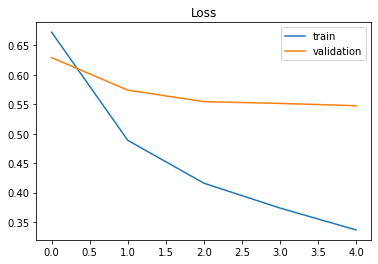

In [24]:
from matplotlib import pyplot as plt

plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.show()

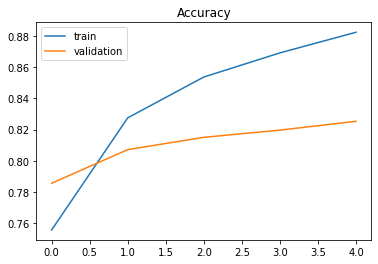

In [26]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.legend()
plt.show();

In [29]:
from sklearn.metrics import classification_report
 
#print('accuracy %s' % accuracy_score(y_pred, Y_test))
print(classification_report(Y_test, y_pred,target_names=cat_id_df['Cat'].values))

ValueError: Classification metrics can't handle a mix of multilabel-indicator and continuous-multioutput targets